<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup" data-toc-modified-id="Imports-and-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup</a></span></li><li><span><a href="#Goal" data-toc-modified-id="Goal-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Goal</a></span><ul class="toc-item"><li><span><a href="#What-do-we-want-to-infer?" data-toc-modified-id="What-do-we-want-to-infer?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>What do we want to infer?</a></span></li><li><span><a href="#What-do-we-want?" data-toc-modified-id="What-do-we-want?-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>What do we want?</a></span></li></ul></li><li><span><a href="#Read-Data" data-toc-modified-id="Read-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Differences-in-score-by-year" data-toc-modified-id="Differences-in-score-by-year-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Differences in score by year</a></span></li><li><span><a href="#Differences-by-country" data-toc-modified-id="Differences-by-country-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Differences by country</a></span></li><li><span><a href="#Facet-Grids" data-toc-modified-id="Facet-Grids-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Facet Grids</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Assumptions-about-&quot;Generative-Story&quot;" data-toc-modified-id="Assumptions-about-&quot;Generative-Story&quot;-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Assumptions about "Generative Story"</a></span></li><li><span><a href="#The-Model" data-toc-modified-id="The-Model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>The Model</a></span></li><li><span><a href="#Building-the-model" data-toc-modified-id="Building-the-model-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Building the model</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

# Imports and setup

A [link](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/rugby_analytics.html) to the tutorial I am following

This is just to help me familiarise myself with PyMC

In [1]:
!date

Wed 05 Jan 2022 15:22:33 NZDT


In [18]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import xarray as xr

In [3]:
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

In [4]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

# Goal

## What do we want to infer?
* We want to infer the latent paremeters (every team’s strength) that are generating the data we observe (the scorelines).

* Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.

* Often we don’t know what the Bayesian Model is explicitly, so we have to ‘estimate’ the Bayesian Model’

* If we can’t solve something, approximate it.

* Markov-Chain Monte Carlo (MCMC) instead draws samples from the posterior.

* Fortunately, this algorithm can be applied to almost any model.

## What do we want?
* We want to quantify our uncertainty

* We want to also use this to generate a model

* We want the answers as distributions not point estimates

# Read Data

In [5]:
df_all = pd.read_csv("rugby.csv")
df_all.head()

,home_team,away_team,home_score,away_score,year
0,ireland,italy,29,11,2010
1,england,wales,30,17,2010
2,scotland,france,9,18,2010
3,wales,scotland,31,24,2010
4,france,ireland,33,10,2010


In [6]:
df_all.describe()

,home_score,away_score,year
count,135.000000,135.000000,135.000000
mean,23.111111,17.970370,2014.000000
std,12.264295,10.347644,2.591605
min,0.000000,0.000000,2010.000000
25%,15.500000,10.500000,2012.000000
50%,21.000000,16.000000,2014.000000
75%,29.000000,22.500000,2016.000000
max,67.000000,63.000000,2018.000000


In [7]:
df_all.shape

(135, 5)

# EDA

## Differences in score by year

In [8]:
df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])
df_all.head()

,home_team,away_team,home_score,away_score,year,difference
0,ireland,italy,29,11,2010,18
1,england,wales,30,17,2010,13
2,scotland,france,9,18,2010,9
3,wales,scotland,31,24,2010,7
4,france,ireland,33,10,2010,23


Text(0, 0.5, 'Average (abs) point difference')

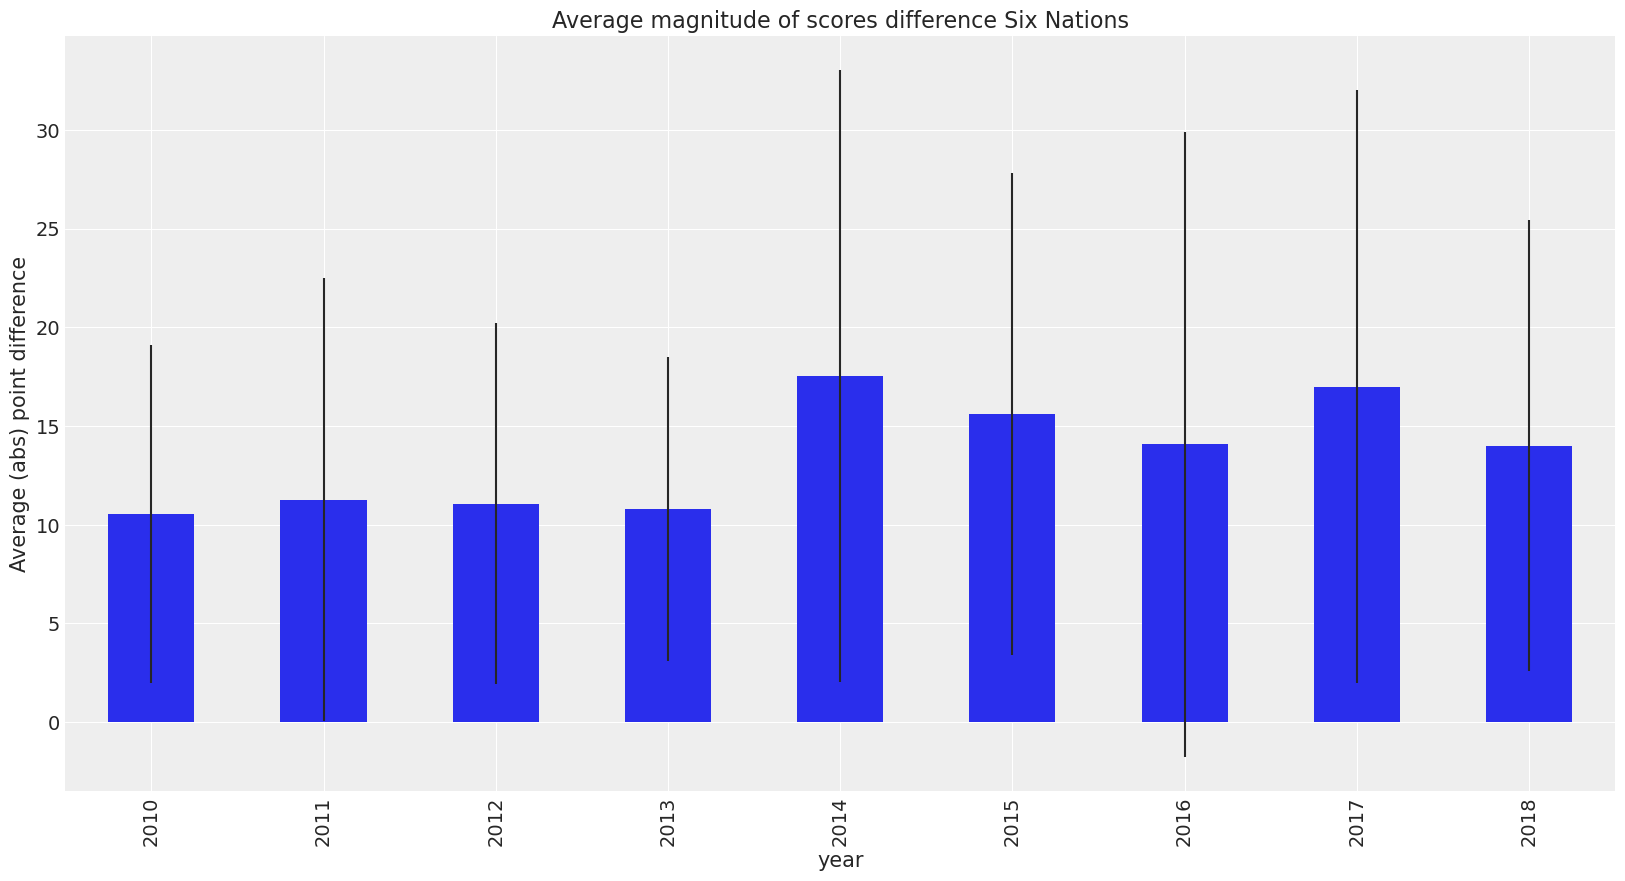

In [9]:
df_grouped = df_all.groupby("year")["difference"].mean()

plt.figure(figsize=(20, 10))

df_grouped.plot(
    kind="bar",
    title="Average magnitude of scores difference Six Nations",
    yerr=df_all.groupby("year")["difference"].std(),
).set_ylabel("Average (abs) point difference")

We can see that the standard error is large. So we can’t say anything about the differences. Let’s look country by country.

## Differences by country

In [10]:
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]

In [11]:
df_all.pivot_table("difference_non_abs", "home_team", "year")

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
home_team,,,,,,,,,
england,4.5,20.000000,7.000000,12.333333,7.000000,20.666667,7.500000,21.333333,-1.500000
france,17.0,16.000000,5.333333,-1.500000,6.666667,0.000000,-2.333333,4.000000,7.000000
ireland,10.0,6.500000,16.000000,-3.000000,28.000000,8.500000,17.666667,7.000000,22.333333
italy,-0.5,-3.000000,1.500000,-1.666667,-21.000000,-31.000000,-23.500000,-33.666667,-16.500000
scotland,-4.5,-2.666667,-6.500000,6.000000,-11.000000,-12.000000,2.500000,16.666667,9.000000
wales,8.0,-0.500000,14.000000,9.500000,25.666667,1.000000,22.000000,4.000000,17.333333


<AxesSubplot:title={'center':'Score difference when playing at home'}, xlabel='home_team'>

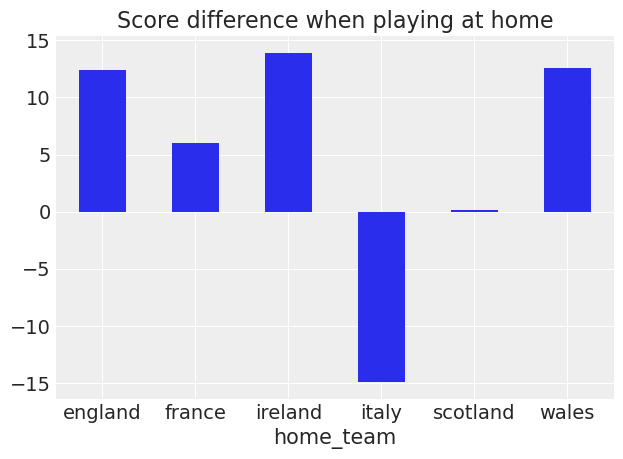

In [15]:
df_all.pivot_table("difference_non_abs", "home_team").plot(
    kind="bar",
    rot=0,
    legend=False,
    title="Score difference when playing at home"
)

We can see that Italy normally has a negative score when they are a home team

We can also see that England, Ireland, and Wales score quite strongly when they are the home team

<AxesSubplot:title={'center':'Score difference against when playing as away team'}, xlabel='away_team'>

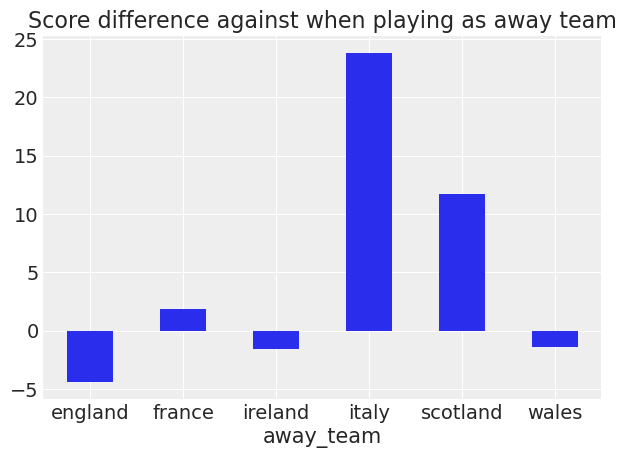

In [16]:
df_all.pivot_table("difference_non_abs", "away_team").plot(
    kind="bar",
    rot=0,
    legend=False,
    title="Score difference against when playing as away team"
)

This trend continues when the teams are playing away from home. 

*(Because the "difference" variable is always home_score - away_score positive numbers here reflect poor performance)*

Italy generally is heavily scored against, same with Scotland.

England, Ireland, and Wales generally score more than their opposition.

## Facet Grids

The above plots don't explain the whole story so it helps to plot every point as a sort of timeseries graph

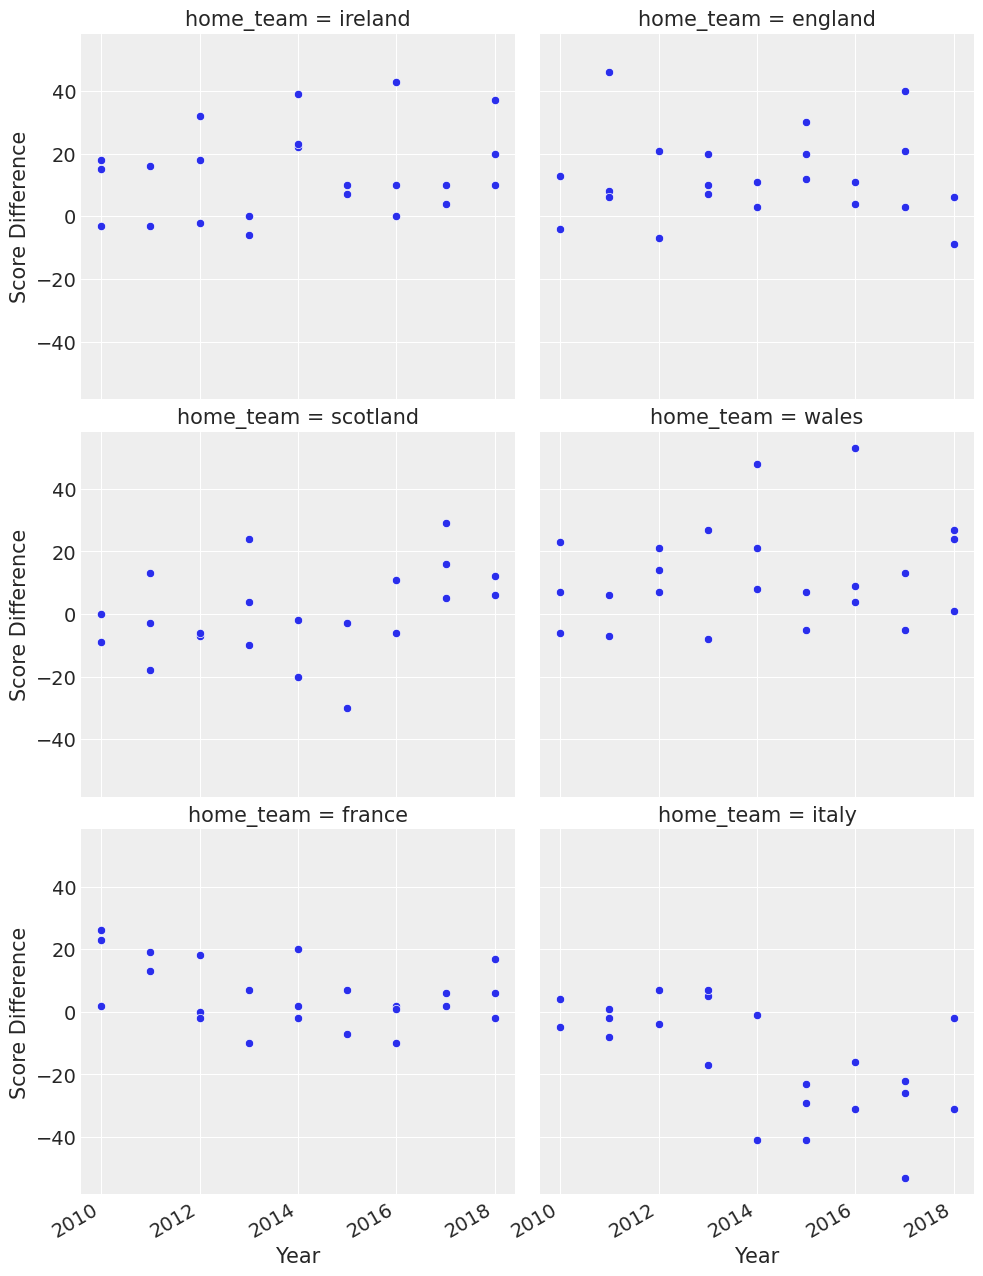

In [14]:
g = sns.FacetGrid(
    df_all,
    col="home_team",
    col_wrap=2,
    height=5
)

g.map(
    sns.scatterplot,
    "year",
    "difference_non_abs"
).set_axis_labels("Year", "Score Difference")

g.fig.autofmt_xdate()

We can see that from around 2014 Italy started performing poorly when playing from home.

Conversly we can see that period as a turning point where Ireland started always beating their opposition (positive scores)

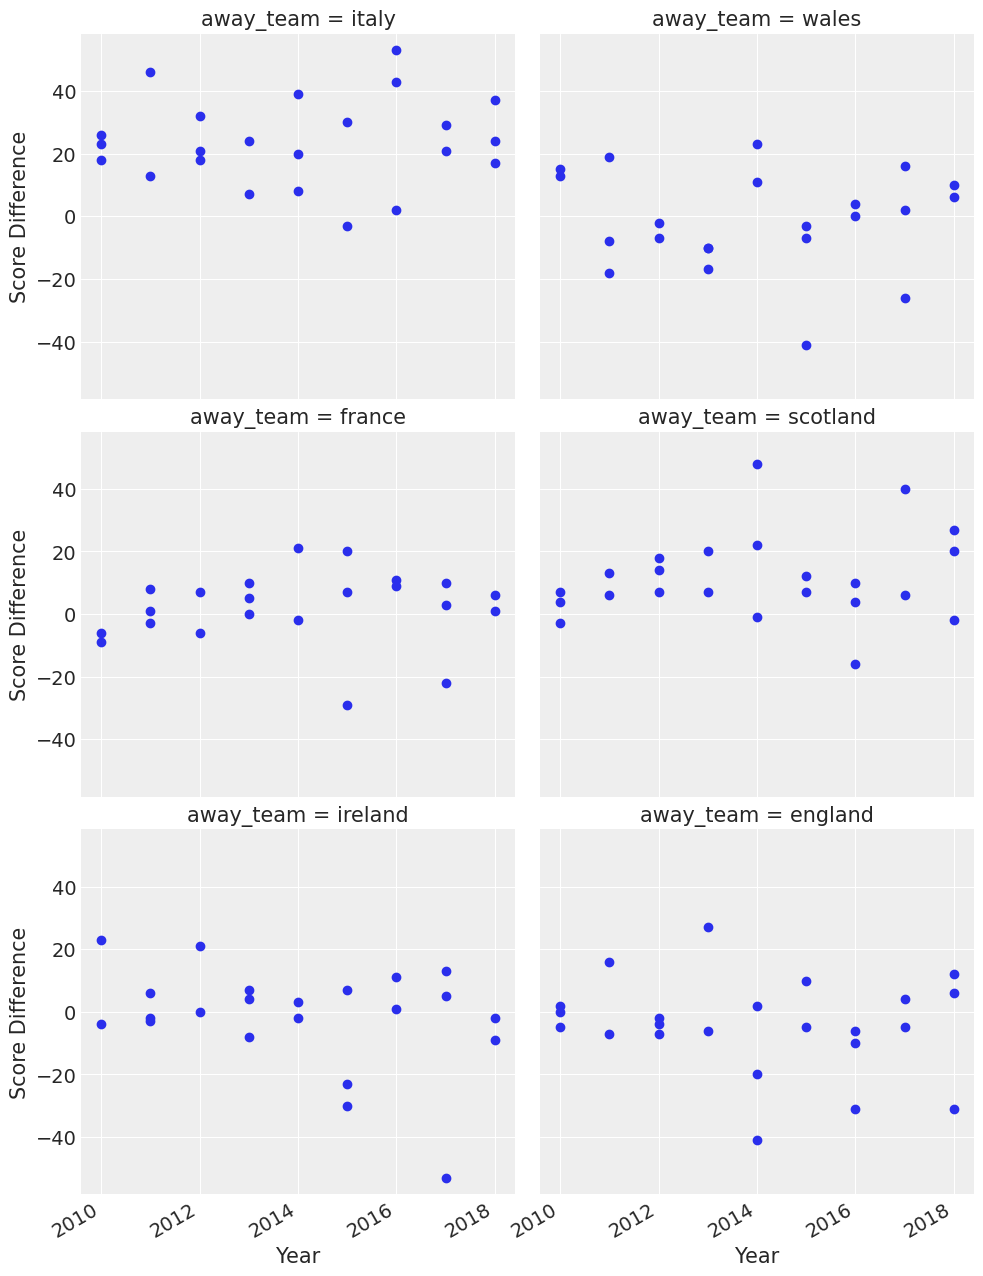

In [15]:
g = sns.FacetGrid(
    df_all,
    col="away_team",
    col_wrap=2,
    height=5,
)

g = g.map(
    plt.scatter,
    "year",
    "difference_non_abs"
).set_axis_labels("Year", "Score Difference")

g.fig.autofmt_xdate()

This set of graphs show that historically Italy does not perform well when playing away games, they consistenly get heavily scored against

The other teams have more varied scores over the years. For example England and Wales swinging between high score losses and high score wins. 

# Modelling

## Assumptions about "Generative Story"

* We know that the Six Nations in Rugby only has 6 teams - they each play each other once

* We have data from the last few years

* We also know that in sports scoring is modelled as a Poisson distribution

* We consider home advantage to be a strong effect in sports

## The Model

The league is made up by a total of $ T= 6 $ teams, playing each other once in a season. We indicate the number of points scored by the home and the away team in the g-th game of the season (15 games) as $ y_{g1} $ and $ y_{g2} $  respectively.

The vector of observed counts $ 𝕪=(y_{g1}, y_{g2}) $ is modelled as independent Poisson: $ y_{gi} | \theta_{gj} Poisson(\theta_{gj}) $
 where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.

We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:

$$ log(\theta)_{g1} = home + att_{h(g)} + def_{a(g)} $$

$$ log(\theta)_{g2} = att_{a(g)} + def_{h(g)} $$

Where $ home $ represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season 

* The log function to away scores and home scores is a standard trick in the sports analytics literature

* The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters $ att $ and $ def $, respectively

* Conversely, for each t = 1, …, T, the team-specific effects are modelled as exchangeable from a common distribution: 
    $$ att_{t} \approx Normal(\mu_{att} , \tau_{att}) $$
    $$ def_{t} \approx Normal(\mu_{def} , \tau_{def}) $$

## Building the model

We now build the model in PyMC3, specifying the global parameters, and the team-specific parameters and the likelihood function

In [19]:
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)

num_games = df_all.shape[0]
coords = {"team": teams, "match": np.arange(num_games)}

In [20]:
with pm.Model(coords=coords) as model:
    
    # constant data
    home_team = pm.Data("home_team", home_idx, dims="match")
    away_team = pm.Data("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - tt.mean(defs_star), dims="team")
    home_theta = tt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = tt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )
    trace = pm.sample(1000, tune=1000, cores=4, return_inferencedata=True, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


* We specified the model and the likelihood function

* All this runs on a Theano graph under the hood

* _return_inferencedata=True_ stores Arviz.InferenceData in trace variable

* Note: To know more about Arviz-PyMC3 integration we can look at the [official documentation](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html)

array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'home'}>,
        <AxesSubplot:title={'center':'home'}>],
       [<AxesSubplot:title={'center':'sd_att'}>,
        <AxesSubplot:title={'center':'sd_att'}>],
       [<AxesSubplot:title={'center':'sd_def'}>,
        <AxesSubplot:title={'center':'sd_def'}>]], dtype=object)

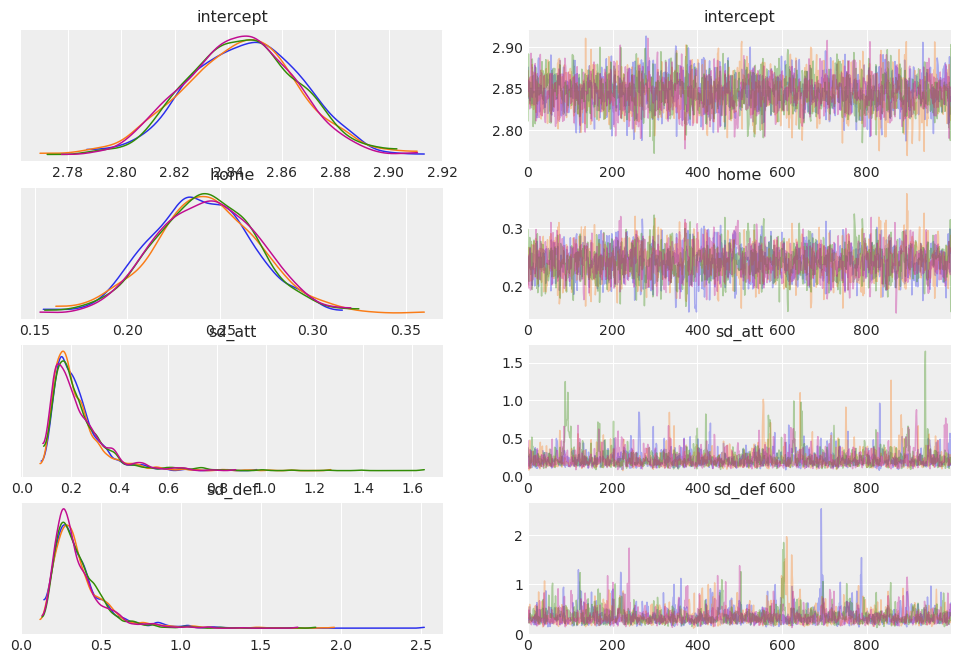

In [21]:
az.plot_trace(trace, var_names=["intercept", "home", "sd_att", "sd_def"], compact=False)

<AxesSubplot:>

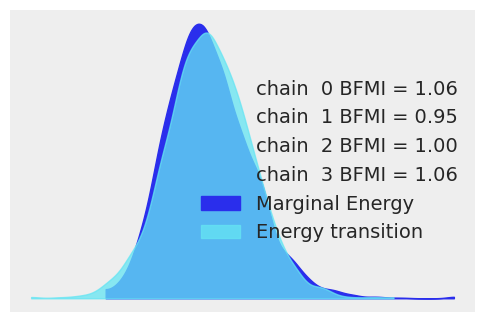

In [22]:
az.plot_energy(trace, figsize=(6, 4))

In [23]:
az.summary(trace, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home,0.001,0.000,2057.0,2537.0,1.0
intercept,0.000,0.000,2396.0,2508.0,1.0
atts_star[england],0.004,0.004,1065.0,777.0,1.0
atts_star[france],0.004,0.004,1042.0,803.0,1.0
atts_star[ireland],0.004,0.004,1045.0,865.0,1.0
atts_star[italy],0.004,0.003,1072.0,927.0,1.0
atts_star[scotland],0.004,0.003,1034.0,810.0,1.0
atts_star[wales],0.004,0.004,1059.0,869.0,1.0
defs_star[england],0.006,0.007,1130.0,1010.0,1.0
defs_star[france],0.006,0.007,1136.0,959.0,1.0


I don't really know what I am looking at so this requires a bit more research.

According to the tutorial this is fine, the $ \vec{\mathbb{R}} $ looks "good"

In [24]:
trace_hdi = az.hdi(trace)
trace_hdi["atts"]

<xarray.DataArray 'atts' (team: 6, hdi: 2)>
array([[ 0.08936965,  0.19829978],
       [-0.05572842,  0.05880375],
       [ 0.04998875,  0.15790088],
       [-0.33472465, -0.19813112],
       [-0.17927635, -0.05739519],
       [ 0.07706108,  0.1842858 ]])
Coordinates:
  * team     (team) object 'england' 'france' 'ireland' ... 'scotland' 'wales'
  * hdi      (hdi) <U6 'lower' 'higher'

In [25]:
trace.posterior["atts"].median(("chain", "draw"))

<xarray.DataArray 'atts' (team: 6)>
array([ 1.42927798e-01,  9.10654573e-05,  1.03640009e-01, -2.63852461e-01,
       -1.15714897e-01,  1.34203500e-01])
Coordinates:
  * team     (team) object 'england' 'france' 'ireland' ... 'scotland' 'wales'

# Results

From the above we can start to understand the different distributions of attacking strength and defensive strength. 

These are probabilisitc estimates and help us better understand the uncertainty in sports and analytics

Text(0.5, 1.0, 'HDI of Team-wise Attack Strength')

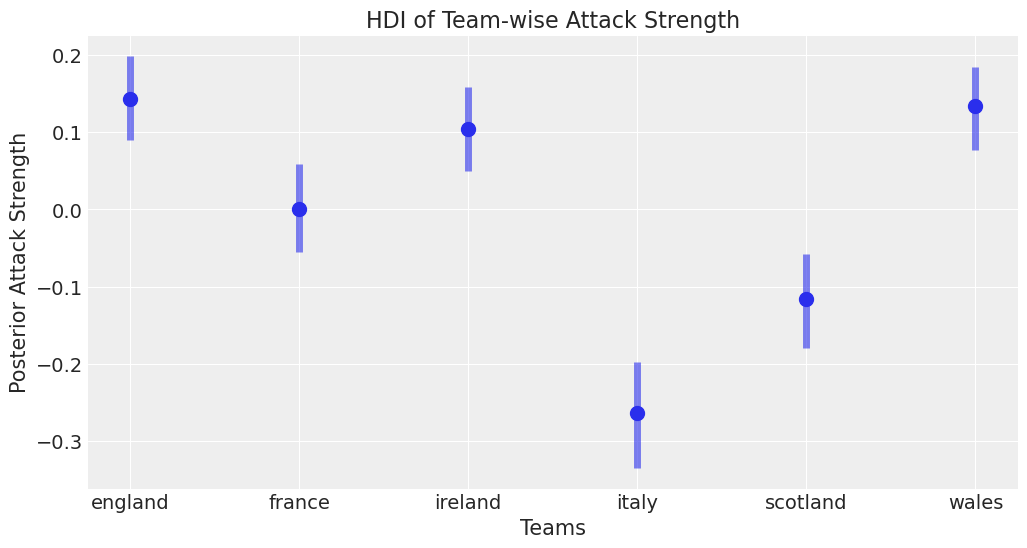

In [28]:
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(teams, trace.posterior["atts"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["atts"].sel({"hdi": "lower"}),
    trace_hdi["atts"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Attack Strength")
ax.set_title("HDI of Team-wise Attack Strength")

This is one of the powerful things about Bayesian modelling, we can have _uncertainty quantification_ of some of our estimates. We've got a Bayesian credible interval for the attack strength of different countries.

We can see an overlap between Ireland, Wales, and England which is what you'd expect since these teams have won the tournament in recent years.

Italy is well behind everyone else.

There are probably some effects we'd like to add in here, like weighting more recent results more strongly however that would complicate the model.

Text(0.5, 1.0, 'Team Offense')

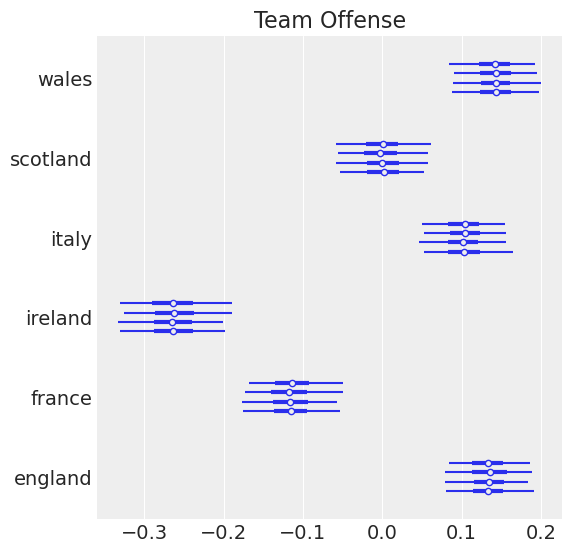

In [29]:
ax = az.plot_forest(trace, var_names=["atts"])
ax[0].set_yticklabels(teams)
ax[0].set_title("Team Offense")

Text(0.5, 1.0, 'Team Defense')

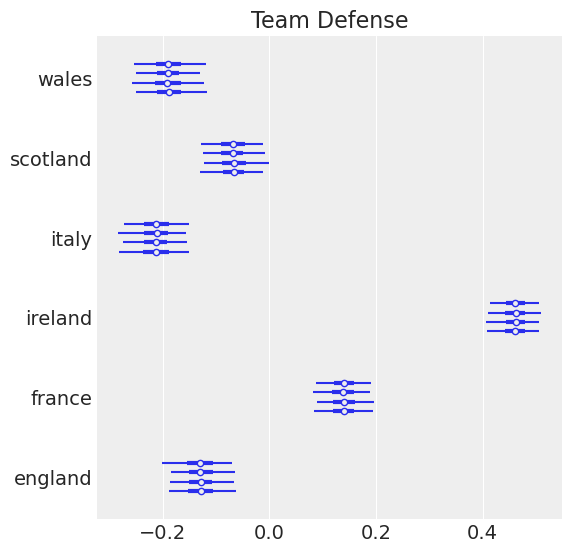

In [30]:
ax = az.plot_forest(trace, var_names=["defs"])
ax[0].set_yticklabels(teams)
ax[0].set_title("Team Defense")